## Harmonic Spectrum Analysis and Total Harmonic Distortion (THD)

1) IQR detect/remove outliers
2) Save IQR summary table
3) Compute THD + EMI features on cleaned data
4) Save per-file & master summaries

In [ ]:

from pathlib import Path
import numpy as np
import pandas as pd

# ====================== CONFIG ======================
ROOT = Path("Harmonics_Data")          # folder with your harmonics_*.csv
PATTERN = "harmonics_*.csv"
OUTDIR = ROOT / "processed"            # outputs go here
IQR_K = 1.5                            # Tukey multiplier (1.5 = standard)
# Columns to apply IQR on (use ones that exist in all files; Mag_1 is robust)
IQR_COLS = ["Mag_1"]                   # add more if you want, e.g. "THD_percent" later
# EMI band definitions (Hz)
BANDS = ((1e5, 3e6), (3e6, 10e6), (10e6, 30e6))
# Thresholds for simple risk flags (tune later as needed)
THR = dict(thd=150.0, slope=-4.0, peak_max=-8.0, peak_count=4,
           band_db={"100000-3000000Hz": -15, "3000000-10000000Hz": -12, "10000000-30000000Hz": -10})
# ==================== /CONFIG =======================

OUTDIR.mkdir(parents=True, exist_ok=True)
IQR_SUMMARY_ROWS = []
FINAL_ROWS_MASTER = []

# ---------- helpers ----------
def detect_cols(df):
    fcols = sorted([c for c in df.columns if c.startswith("Frequency_") and c.endswith("_Hz")],
                   key=lambda c: int(c.split("_")[1]))
    mcols = sorted([c for c in df.columns if c.startswith("Mag_")],
                   key=lambda c: int(c.split("_")[1]))
    pcols = sorted([c for c in df.columns if c.startswith("Phase_")],
                   key=lambda c: int(c.split("_")[1]))
    return fcols, mcols, pcols

def thd_from_mags(mags):
    mags = np.asarray(mags, float)
    if mags.size == 0 or not np.isfinite(mags[0]) or mags[0] == 0:
        return np.nan
    harm = mags[1:][np.isfinite(mags[1:])]
    return 100.0 * (np.sqrt(np.sum(harm**2)) / mags[0]) if harm.size else 0.0

def to_dB_rel_fund(mags):
    mags = np.asarray(mags, float)
    ref = mags[0] if np.isfinite(mags[0]) and mags[0] > 0 else 1.0
    with np.errstate(divide='ignore', invalid='ignore'):
        return 20*np.log10(np.clip(mags, 1e-30, None)/ref)

def noise_floor_db(db_vals, start_order=30):
    dv = np.asarray(db_vals, float)
    if dv.size <= start_order: return np.nan
    return np.nanmedian(dv[start_order:])

def decay_slope(db_vals, start_k=3, end_k=30):
    k = np.arange(1, len(db_vals)+1)
    sel = (k >= start_k) & (k <= min(end_k, len(k)))
    if sel.sum() < 3: return np.nan
    x = np.log10(k[sel]); y = np.asarray(db_vals)[sel]
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return float(m)  # dB/decade of harmonic order

def band_power(freqs, db_vals, bands):
    mags_rel = 10**(np.asarray(db_vals)/20.0)
    out = {}
    for (lo, hi) in bands:
        mask = (freqs >= lo) & (freqs < hi)
        val = mags_rel[mask].sum()
        key = f"{int(lo)}-{int(hi)}Hz"
        out[key] = 20*np.log10(val) if val > 0 else -np.inf
    return out

def peaks_over_floor(db_vals, floor_db, margin_db=10.0, min_order=3):
    dbv = np.asarray(db_vals, float)
    if dbv.size < 5: return 0, -np.inf
    # crude local peak detection (no SciPy): greater than neighbors
    is_peak = (dbv[1:-1] > dbv[:-2]) & (dbv[1:-1] > dbv[2:])
    idx = np.where(is_peak)[0] + 1
    idx = idx[idx >= (min_order-1)]
    thr = (floor_db if np.isfinite(floor_db) else np.nanmedian(dbv)) + margin_db
    tall = idx[dbv[idx] > thr]
    count = int(tall.size)
    max_peak = float(np.max(dbv[tall])) if count else -np.inf
    return count, max_peak

def iqr_mask(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return (series < q1 - k*iqr) | (series > q3 + k*iqr)

def apply_iqr_filter(df, cols, k=1.5):
    """Remove rows that are outliers in ANY of the given columns. Returns filtered df and counts dict."""
    if not cols: return df.copy(), {}
    mask_any = pd.Series(False, index=df.index)
    counts = {}
    for c in cols:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            m = iqr_mask(df[c].dropna(), k=k)
            m_full = pd.Series(False, index=df.index); m_full.loc[m.index] = m
            counts[c] = int(m.sum())
            mask_any |= m_full
    return df.loc[~mask_any].copy(), counts

def compute_features(df, bands=BANDS):
    fcols, mcols, pcols = detect_cols(df)
    rows = []
    for _, r in df.iterrows():
        mags = pd.to_numeric(r[mcols], errors="coerce").to_numpy(float)
        freqs = pd.to_numeric(r[fcols], errors="coerce").to_numpy(float)
        ok = np.isfinite(freqs) & np.isfinite(mags)
        freqs, mags = freqs[ok], mags[ok]
        if mags.size == 0:
            continue
        thd = thd_from_mags(mags)
        db = to_dB_rel_fund(mags)
        floor = noise_floor_db(db, start_order=30)
        slope = decay_slope(db)
        band_db = band_power(freqs, db, bands)
        pk_count, pk_max = peaks_over_floor(db, floor_db=floor, margin_db=10.0)

        feat = {
            "THD_percent": thd,
            "DecaySlope_dB_per_decade": slope,
            "NoiseFloor_dB": floor,
            "PeakCount_gt_floor+10dB": pk_count,
            "PeakMax_dB": pk_max,
        }
        feat.update(band_db)
        # keep useful parameters if present
        for c in ["Vbus","Rg","Ls4","Ls5","Ls6","Ls7","Ls8","Ls9","Ls10","Ls11","Measurement"]:
            if c in df.columns: feat[c] = r[c]
        rows.append(feat)
    return pd.DataFrame(rows)

def add_risk_flags(tbl, thr=THR):
    tbl = tbl.copy()
    reasons = []
    for _, r in tbl.iterrows():
        why = []
        if pd.notna(r.get("THD_percent")) and r["THD_percent"] > thr["thd"]:
            why.append(f"THD>{thr['thd']}%")
        if pd.notna(r.get("DecaySlope_dB_per_decade")) and r["DecaySlope_dB_per_decade"] > thr["slope"]:
            why.append(f"slope>{thr['slope']} dB/dec")
        if pd.notna(r.get("PeakMax_dB")) and r["PeakMax_dB"] > thr["peak_max"]:
            why.append(f"peak>{thr['peak_max']} dB")
        pc_col = "PeakCount_gt_floor+10dB"
        if pd.notna(r.get(pc_col)) and r[pc_col] >= thr["peak_count"]:
            why.append(f"peaks≥{thr['peak_count']}")
        for band, lim in thr["band_db"].items():
            if band in tbl.columns and pd.notna(r.get(band)) and r[band] > lim:
                why.append(f"{band}>{lim} dB")
        reasons.append("; ".join(why))
    tbl["EMI_Flag"] = reasons
    tbl["EMI_Risky"] = tbl["EMI_Flag"].astype(bool)
    return tbl

# ---------- pipeline per file ----------
def process_file(csv_path: Path):
    print(f"\n==> {csv_path.name}")
    df = pd.read_csv(csv_path)

    # 1) IQR filter on selected columns (only if the columns exist)
    cols = [c for c in IQR_COLS if c in df.columns]
    filtered_df, counts = apply_iqr_filter(df, cols, k=IQR_K)

    # save IQR summary row
    row_info = {"file": csv_path.name, "original_rows": len(df), "kept_rows": len(filtered_df)}
    for c in cols: row_info[f"outliers_{c}"] = counts.get(c, 0)
    IQR_SUMMARY_ROWS.append(row_info)

    # save cleaned file
    clean_path = OUTDIR / f"{csv_path.stem}_clean.csv"
    filtered_df.to_csv(clean_path, index=False)

    # 2) Compute features (THD + EMI) on cleaned data
    feats = compute_features(filtered_df, bands=BANDS)
    feats = add_risk_flags(feats, thr=THR)

    # save per-file results
    feats_path = OUTDIR / f"{csv_path.stem}_features.csv"
    feats.to_csv(feats_path, index=False)

    # add to master
    feats_insert = feats.copy()
    feats_insert.insert(0, "SourceFile", csv_path.name)
    FINAL_ROWS_MASTER.append(feats_insert)

    # quick console summary
    if not feats.empty:
        print("  THD%  (median/IQR):",
              f"{feats['THD_percent'].median():.1f} / "
              f"{(feats['THD_percent'].quantile(0.75) - feats['THD_percent'].quantile(0.25)):.1f}")
        print("  Risky rows:", feats["EMI_Risky"].sum(), "of", len(feats))

# ---------- run ----------
def main():
    files = sorted(ROOT.glob(PATTERN))
    if not files:
        print(f"No files in {ROOT} matching {PATTERN}")
        return

    for f in files:
        process_file(f)

    # Save IQR summary table
    iqr_summary = pd.DataFrame(IQR_SUMMARY_ROWS)
    iqr_summary.to_csv(OUTDIR / "iqr_summary.csv", index=False)

    # Save master table
    if FINAL_ROWS_MASTER:
        master = pd.concat(FINAL_ROWS_MASTER, ignore_index=True)
        master.to_csv(OUTDIR / "emi_master_features.csv", index=False)

    print("\nDone.")
    print(f"- IQR summary: {OUTDIR/'iqr_summary.csv'}")
    print(f"- Per-file features: {OUTDIR}/<file>_features.csv")
    print(f"- Master features: {OUTDIR/'emi_master_features.csv'}")

if __name__ == "__main__":
    main()


ERROR! Session/line number was not unique in database. History logging moved to new session 491

==> harmonics_C2M0025120D.csv
  THD%  (median/IQR): 153.1 / 146.0
  Risky rows: 3210 of 3210

==> harmonics_C2M0040120D.csv
  THD%  (median/IQR): 159.4 / 98.6
  Risky rows: 2470 of 2470

==> harmonics_C2M0080120D.csv
  THD%  (median/IQR): 155.6 / 132.9
  Risky rows: 8115 of 8115

==> harmonics_C2M0160120D.csv
  THD%  (median/IQR): 121.7 / 89.7
  Risky rows: 1915 of 1915

==> harmonics_C2M0280120D.csv
  THD%  (median/IQR): 144.7 / 149.7
  Risky rows: 3470 of 3470

==> harmonics_C2M1000170D.csv
  THD%  (median/IQR): 183.1 / 164.8
  Risky rows: 4105 of 4105

Done.
- IQR summary: Harmonics_Data\processed\iqr_summary.csv
- Per-file features: Harmonics_Data\processed/<file>_features.csv
- Master features: Harmonics_Data\processed\emi_master_features.csv


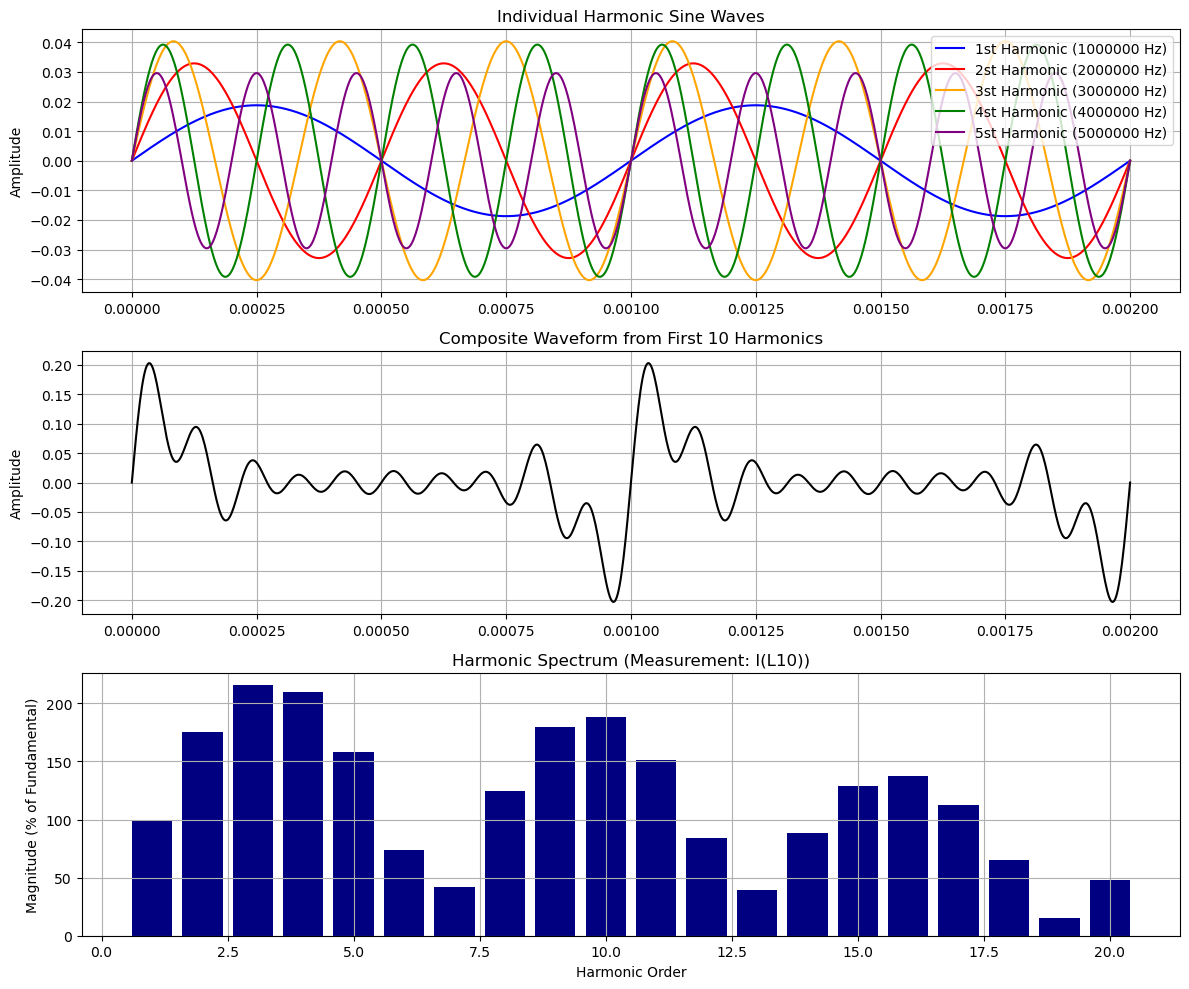

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the harmonic spectrum data
csv_path = "harmonics_C2M0025120D.csv"
df = pd.read_csv(csv_path)

# Extract 1 row of FFT data
row = df.iloc[0]  # first row
measurement = row['Measurement']
dc_component = row['DC_Component']

# Extract frequencies and magnitudes from the row
frequencies = []
magnitudes = []

for i in range(1, 101):
    freq = row[f'Frequency_{i}_Hz']
    mag = row[f'Mag_{i}']
    if not (np.isnan(freq) or np.isnan(mag)):
        frequencies.append(freq)
        magnitudes.append(mag)

frequencies = np.array(frequencies)
magnitudes = np.array(magnitudes)

# Normalize magnitudes by fundamental (assume 1st is fundamental)
fundamental_mag = magnitudes[0]
harmonic_order = np.arange(1, len(frequencies)+1)
magnitudes_percent = (magnitudes / fundamental_mag) * 100

# Create 3 subplots like the examples shown
fig, axs = plt.subplots(3, 1, figsize=(12, 10), tight_layout=True)

# Plot 1: First 5 harmonics as individual sine waves
t = np.linspace(0, 2e-3, 1000)  # 2ms window
colors = ['blue', 'red', 'orange', 'green', 'purple']
for i in range(5):
    f = frequencies[i]
    A = magnitudes[i]
    axs[0].plot(t, A * np.sin(2 * np.pi * f * t), label=f'{i+1}st Harmonic ({int(f)} Hz)', color=colors[i])
axs[0].set_title('Individual Harmonic Sine Waves')
axs[0].set_ylabel('Amplitude')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot 2: Composite waveform (sum of first 10 harmonics)
composite = np.zeros_like(t)
for i in range(10):
    composite += magnitudes[i] * np.sin(2 * np.pi * frequencies[i] * t)
axs[1].plot(t, composite, color='black')
axs[1].set_title('Composite Waveform from First 10 Harmonics')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

# Plot 3: Harmonic Spectrum Bar Plot
axs[2].bar(harmonic_order[:20], magnitudes_percent[:20], color='navy')
axs[2].set_title(f'Harmonic Spectrum (Measurement: {measurement})')
axs[2].set_xlabel('Harmonic Order')
axs[2].set_ylabel('Magnitude (% of Fundamental)')
axs[2].grid(True)

plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_28884\1335376098.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


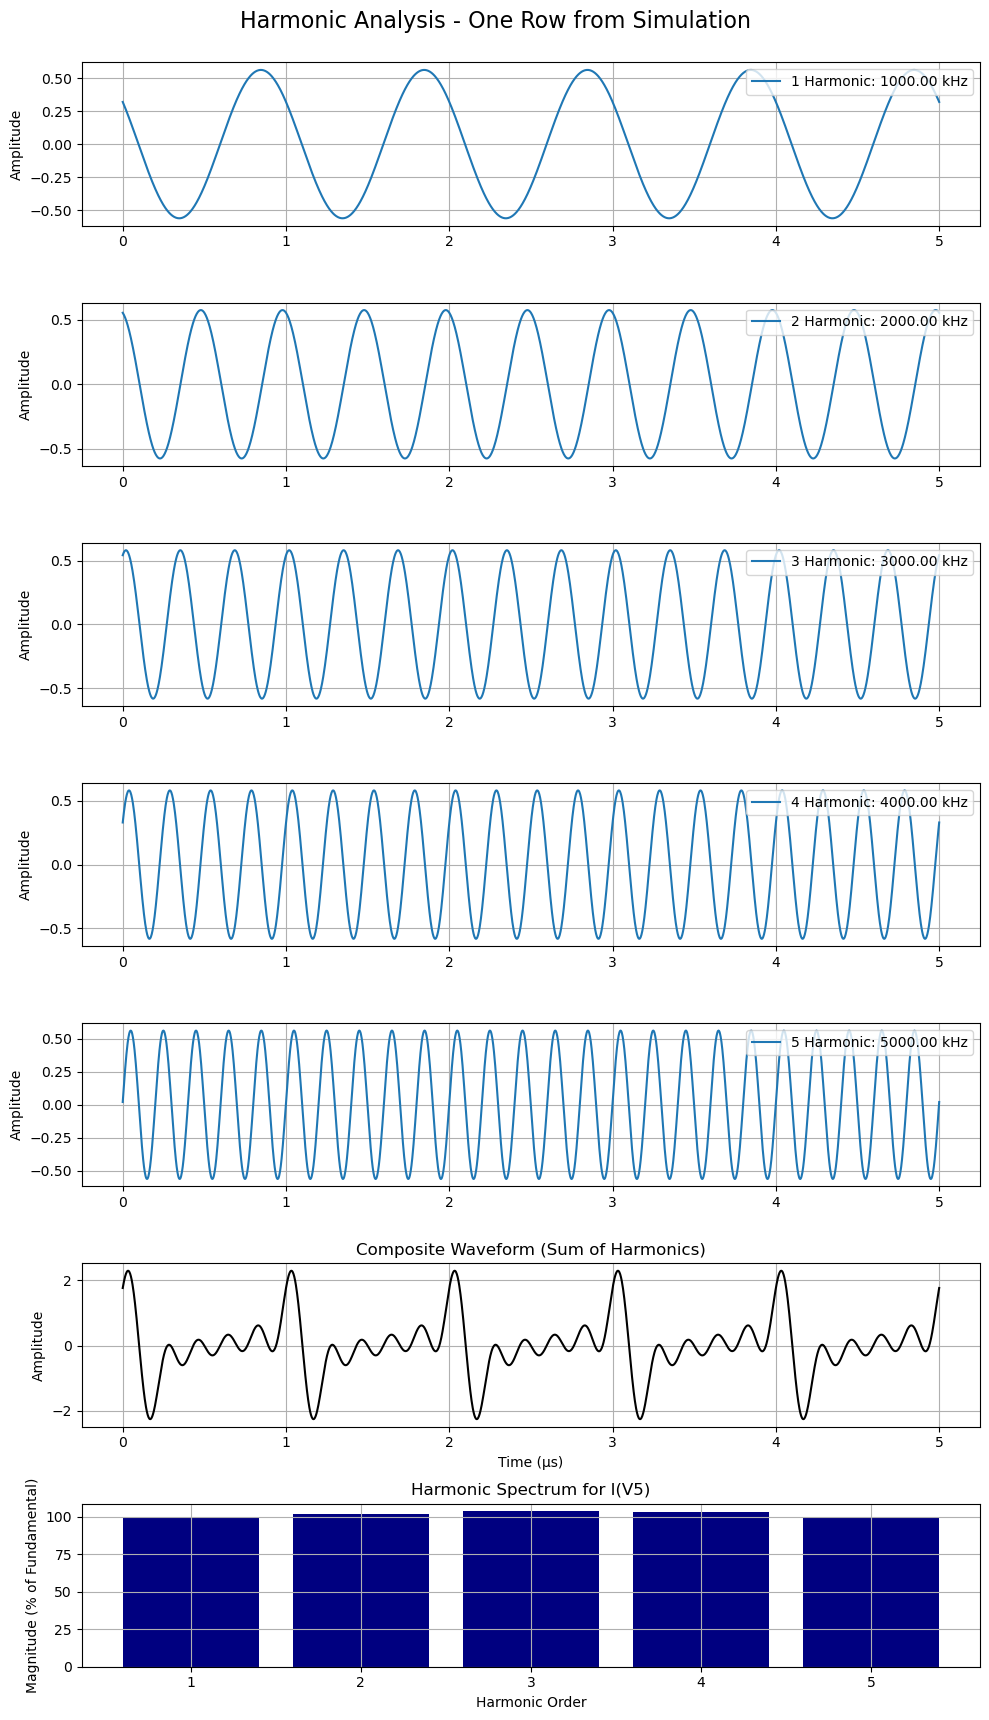

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

# Load the harmonics CSV
file_path = "harmonics_C2M0025120D.csv"
df = pd.read_csv(file_path)

# Choose one measurement row (example: first row where Measurement == 'I(V5)')
row = df[df['Measurement'] == 'I(V5)'].iloc[0]

# Extract fundamental and first N harmonics
N = 5
frequencies = [float(row[f'Frequency_{i}_Hz']) for i in range(1, N + 1)]
magnitudes = [float(row[f'Mag_{i}']) for i in range(1, N + 1)]
phases = [float(row[f'Phase_{i}']) for i in range(1, N + 1)]

# Normalize magnitudes by fundamental (Mag_1)
magnitudes_percent = [100 * m / magnitudes[0] for m in magnitudes]

# Time vector
t = np.linspace(0, 1 / frequencies[0] * 5, 2000)  # 5 periods of fundamental

# Generate harmonic waveforms and sum
harmonics = [m * np.sin(2 * np.pi * f * t + np.deg2rad(p))
             for m, f, p in zip(magnitudes, frequencies, phases)]
composite = np.sum(harmonics, axis=0)

# Plotting
fig, axs = plt.subplots(N + 2, 1, figsize=(10, 2.5 * (N + 2)), constrained_layout=True)

# Plot individual harmonics
for i, h in enumerate(harmonics):
    axs[i].plot(t * 1e6, h, label=f"{i+1} Harmonic: {frequencies[i]/1e3:.2f} kHz")
    axs[i].legend(loc='upper right')
    axs[i].set_ylabel("Amplitude")
    axs[i].grid(True)

# Composite waveform
axs[N].plot(t * 1e6, composite, color='black')
axs[N].set_title("Composite Waveform (Sum of Harmonics)")
axs[N].set_ylabel("Amplitude")
axs[N].set_xlabel("Time (µs)")
axs[N].grid(True)

# Bar plot of harmonic spectrum
axs[N + 1].bar(range(1, N + 1), magnitudes_percent, color='navy')
axs[N + 1].set_xticks(range(1, N + 1))
axs[N + 1].set_xlabel("Harmonic Order")
axs[N + 1].set_ylabel("Magnitude (% of Fundamental)")
axs[N + 1].set_title(f"Harmonic Spectrum for {row['Measurement']}")
axs[N + 1].grid(True)

plt.suptitle("Harmonic Analysis - One Row from Simulation", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()
